In karaoke, lyrics are presented on screen in rough synchronization with the appropriate portion of the song. However, unless manually done, the lyric guide (pointer/highlight over the appropriate word to be sung at a time) is absent. I attempt to automate this process.

The high level idea is to use a pre-trained network (RNN?) on speech transcription, then use a similar idea to an image heatmap in CNNs to find the portion of the audio input that contributed most to the chosen word. With these time markers, we now have a lyric guide.

Background: speech-to-text networks, CNN heatmaps

Formally, this is known as the "forced alignment problem"

## Apporach 1: Using GRAD-CAM on CNN's

#### For this, I will use end-to-end CNN's for ASR and apply the GRAD-CAM method described by Selvaraju et. al (2016) in [this paper](https://arxiv.org/abs/1610.02391). These approaches will follow a Connecitonist Temporal Classification (CTC) model.

### Approach 1a: I will implement [this paper](https://arxiv.org/pdf/1701.02720.pdf) by Zhang et. al (2017) for the CNN.

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

False

In [4]:
""" Preprocessing

Note: nn in torch expects everything as mini-batches, so single sample should be mini-batch of size 1

1. Get input audio from dataset (TIMIT, LibraSpeech)
2. Do appropriate transformations to get input features
3. Split into Training, Validation, and Test (use DataLoader)

"""

' Preprocessing\n\nNote: nn in torch expects everything as mini-batches, so single sample should be mini-batch of size 1\n\n1. Get input audio from dataset (TIMIT, LibraSpeech)\n2. Split into Training, Validation, and Test (use DataLoader)\n3. Do appropriate transformations to get input features\n\n'

In [25]:
def get_libri_speech_dataset(dataset_dir: str, dataset: str="train-clean-100") -> torch.utils.data.Dataset:

    """
    Function to download LibriSpeech dataset.

    Inputs: 
    dataset_dir -- Path to directory where dataset should be located/downloaded
    dataset -- Type of dataset desired. Options are "train-clean-100", "train-clean-360", "train-clean-500", "dev-clean", "dev-other", "test-clean", "test-other"
    dataset

    Output: torch.utils.data.Dataset of tuples with contents (waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id)
    """

    # can use either key or url for "url" parameter of dataset download function
    # libra_speech_urls = {"train-clean-100" : "https://www.openslr.org/resources/12/train-clean-100.tar.gz", \
    #                     "train-clean-360" : "https://www.openslr.org/resources/12/train-clean-360.tar.gz", \
    #                     "train-clean-500" : "https://www.openslr.org/resources/12/train-other-500.tar.gz", \
    #                     "dev-clean" : "https://www.openslr.org/resources/12/dev-clean.tar.gz", \
    #                     "dev-other" : "https://www.openslr.org/resources/12/dev-other.tar.gz", \
    #                     "test-clean" : "https://www.openslr.org/resources/12/test-clean.tar.gz", \
    #                     "test-other" : "https://www.openslr.org/resources/12/test-other.tar.gz"}

    return torchaudio.datasets.LIBRISPEECH(dataset_dir, url=dataset, download=True)

PATH_TO_DATASET_DIR = "/mnt/d/Datasets/"

train_dataset = get_libri_speech_dataset(PATH_TO_DATASET_DIR)
dev_dataset = get_libri_speech_dataset(PATH_TO_DATASET_DIR, "dev-clean")
test_dataset = get_libri_speech_dataset(PATH_TO_DATASET_DIR, "test-clean")

100.0%


In [114]:
def features_from_waveform(waveform):

    """
    Raw audio is transformed into 40-dimensional log mel-filter-bank (plus energy term) coefficients with deltas and delta-deltas, which reasults in 123 dimensional features. Each dimension is normalized to have zero mean and unit variance over the training set.

    Basically this is just MFCC but without taking DCT at the end, but for the sake of cleanliness, I'll stick with MFCC for now. Also, I don't know what they mean by "energy term" (aren't the coefficients already energy terms?) so I'm omitting that.
    """

    data = waveform.squeeze(dim=0)

    # Grab desired features
    # Takes in audio of dimension (..., time) returns specgram_mel of size (..., n_mfcc, time) where n_mfcc defaults to 40
    mfcc_features = torchaudio.transforms.MFCC(log_mels=True)(data)
    deltas = torchaudio.functional.compute_deltas(mfcc_features)
    delta_deltas = torchaudio.functional.compute_deltas(deltas)

    # Stack features together
    input_features = torch.cat((mfcc_features, deltas, delta_deltas), 0)

    # Normalize features along time dimension
    # PyTorch built in Normalize transform does it to entire channels, we want along specific dimension of only channel

    # A nicer way of normalizing by using unsqueeze, seems more legit than the transpose method
    input_features_normalized = (input_features - input_features.mean(1).unsqueeze(1)) / input_features.std(1).unsqueeze(1)

    # Old ways of experimenting with normalizing along dimensions. 

    # Transpose method: A super ugly way to normalize (0 mean, unit variance) along each x dimension, have to transpose everything
    # input_features_normalized = ((input_features.T - input_features.T.mean(0)) / input_features.T.std(0)).T

    # Numpy method: Using a useful function numpy has but torch does not. Creates small floating point differences, probably from conversion to torch tensor from numpy array.
    # input_features_normalized = torch.from_numpy(np.apply_along_axis(lambda x : (x - np.mean(x)) / np.std(x), 1, input_features))

    return input_features_normalized



In [115]:
test_input = features_from_waveform(train_dataset[1][0])

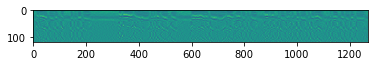

In [116]:
plt.imshow(test_input)

In [14]:
def maxout():
    pass

class Conv_Maxout_Layer(nn.Module):

    def __init__(self, in_channels, out_channels, filter_dim=(3,5), pool=False, pool_dim=(3,1), dropout=0.3):
        super(Conv_Maxout_Layer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=filter_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.conv(x)
        # TODO: implement maxout activation
        if pool:
            x = nn.MaxPool2d(kernel_size=pool_dim)(x)
        x = self.dropout(x)
        return x

class FC_Layer(nn.Module):

    def __init__(self, in_dim, out_dim, dropout=0.3):
        super(FC_Layer, self).__init__()

        self.fc = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(p=dropout)

        def forward(self, x):
            x = self.fc(x)
            # maxout
            x = self.dropout(x)
            return x

class ASR_1(nn.Module):

        """
        Unlike the other layers, the first convolutional layer is followed by a pooling layer, which is described in section 2. The pooling size is 3 × 1, which mean swe only pool over the frequency axis. The filter size is 3 × 5 across the layers. The model has 128 feature maps in the first four convolutional layers and 256 feature maps in the remaining six convolutional layers. Each fully-connected layer has 1024 units. Maxout with 2 piece-wise linear functions is used as the activation function.
        """ 

        def __init__(self, in_dim, out_dim):
            super(ASR_1, self).__init__()
            # in_dim should be 40-dimensional from log MFCC + extra from deltas and delta-deltas = 123 total
            # should just be equal to dimensions of input features
            self.in_dim = in_dim 
            self.cnn_layers = nn.Sequential(
                            Conv_Maxout_Layer(self.in_dim, 128, pool=True, dropout=0),
                            Conv_Maxout_Layer(128, 128),
                            Conv_Maxout_Layer(128, 128),
                            Conv_Maxout_Layer(128, 128),
                            Conv_Maxout_Layer(128, 256),
                            Conv_Maxout_Layer(256, 256),
                            Conv_Maxout_Layer(256, 256),
                            Conv_Maxout_Layer(256, 256),
                            Conv_Maxout_Layer(256, 256),
                            Conv_Maxout_Layer(256, 256),
            )

            self.fc_layers = nn.Sequential(
                            FC_Layer(1, 1024),
                            FC_Layer(1024, 1024),
                            FC_Layer(1024, 1024),
                            FC_Layer(1024, out_dim, dropout=0)
            )

            # self.conv1 = nn.Conv2d(self.in_dim, 128, (3, 5))
            # self.pool = nn.MaxPool2d((3, 1))
            # self.conv2 = nn.Conv2d(128, 128, (3, 5))
            # self.conv3 = nn.Conv2d(128, 128, (3, 5))
            # self.conv4 = nn.Conv2d(128, 128, (3, 5))
            # self.conv5 = nn.Conv2d(128, 256, (3, 5))
            # self.conv6 = nn.Conv2d(256, 256, (3, 5))
            # self.conv7 = nn.Conv2d(256, 256, (3, 5))
            # self.conv8 = nn.Conv2d(256, 256, (3, 5))
            # self.conv9 = nn.Conv2d(256, 256, (3, 5))
            # self.conv10 = nn.Conv2d(256, 256, (3, 5))
            # first arg of fc1 should be w * h of input features * 256
            # self.fc1 = nn.Linear(1, 1024)
            # self.fc2 = nn.Linear(1024, 1024)
            # need to add last layer for character classes (+ blank for CTC?)


        def forward(self, x):
            x = self.cnn_layers(x)
            # transfomration from cnn dimensions to fc dimensions
            x = self.fc_layers(x)
            return x


In [15]:
net = ASR_1()
net

TypeError: __init__() missing 2 required positional arguments: 'in_dim' and 'out_dim'

In [12]:
params = list(net.parameters())
len(params)

24

In [13]:
# ADAM loss w/ lr=10e-4, batch size 20, initial weights initialized uniformly from [-0.05, 0.05], dropout w/ p=0.3 used in all layers except in and out
# for fine tuning: SGD w/ lr 10e-5, l2 penalty w/ coeff=1e-5

loss = nn.CTCLoss()(ouput, labels, input_lengths, label_lengths)